A notebook which contains an evaluation of the SalishSeaCast model within PugetSound. More specifically, it compares Observed data on temperature, salinity, and chlorophyll concentrations  collected from CTD data and compares it to various model phytoplankon outputs. This evaluation includes scatter plots and 2d histograms visualizing the similarity of observed and model data as well as tables of evaluation statistics. 

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
years=[2009,2010]
year=2010
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/kflanaga/MEOPAR/savedData/WADE_CTD_pickles'

In [4]:
# Parameters
years = [2014, 2015]
year = 2015
modver = "nowcast-green.201905"
PATH = "/results2/SalishSea/nowcast-green.201905/"
datadir = "/ocean/kflanaga/MEOPAR/savedData/WADE_CTD_pickles"


In [5]:
display(Markdown('''## Year: '''+ str(year)))

## Year: 2015

In [6]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of chlorophyll, temperature and salinity between 201905 runs and CTD observations

In [7]:
##### Loading in pickle file data
with open(os.path.join(datadir,f'data_CTD_{modelversion}_{year}.pkl'),'rb') as hh:
    data_all=pickle.load(hh)

In [8]:
#Adding extra columns to assist in analysis.

Chl_to_N=1.8
data_all['log_Chl']=ket.logt(data_all['Chl'])
data_all['log_mod_diatoms']=ket.logt(data_all['mod_diatoms']*Chl_to_N)
data_all['log_mod_ciliates']=ket.logt(data_all['mod_ciliates']*Chl_to_N)
data_all['log_mod_flagellates']=ket.logt(data_all['mod_flagellates']*Chl_to_N)
data_all['mod_Chl']=((data_all['mod_diatoms']*Chl_to_N)+(data_all['mod_ciliates']*Chl_to_N)+(data_all['mod_flagellates']*Chl_to_N))
data_all['log_mod_Chl']=ket.logt((data_all['mod_diatoms']*Chl_to_N)+(data_all['mod_ciliates']*Chl_to_N)+(data_all['mod_flagellates']*Chl_to_N))

/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# Creating seperate dataframes for each season (includes only dataabove 15 metre depth.)
iz=(data_all.Z<15)
DJF_CTD=data_all.loc[iz&(data_all.dtUTC>=dt.datetime(years[0],12,1))&(data_all.dtUTC<=dt.datetime(years[1],3,1)),:]
MAM_CTD=data_all.loc[iz&(data_all.dtUTC<=dt.datetime(years[1],6,1))&(data_all.dtUTC>dt.datetime(years[1],3,1)),:]
JJA_CTD=data_all.loc[iz&(data_all.dtUTC<=dt.datetime(years[1],9,1))&(data_all.dtUTC>dt.datetime(years[1],6,1)),:]
SON_CTD=data_all.loc[iz&(data_all.dtUTC>dt.datetime(years[1],9,1))&(data_all.dtUTC<=dt.datetime(years[1],11,30)),:]

In [10]:
data_CTD=data_all.loc[(data_all.dtUTC>=dt.datetime(years[0],12,1))&(data_all.dtUTC<=dt.datetime(years[1],11,30)),:]

In [11]:
# defning a dictionary that brakes the data down by individual stations
datstat_CTD=dict()
for ind, istation in enumerate(data_CTD.Station.unique()):
    datstat_CTD[istation]=data_CTD.loc[data_CTD.Station == istation]

datreg_CTD=dict()
for iregion in data_CTD.Basin.unique():
    datreg_CTD[iregion] = data_CTD.loc[data_CTD.Basin==iregion]

In [12]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs_CTD=OrderedDict({'z < 15 m':data_CTD.loc[data_CTD.Z<15],
                      '15 m < z < 22 m':data_CTD.loc[(data_CTD.Z>=15)&(data_CTD.Z<22)],
                      'z >= 22 m':data_CTD.loc[data_CTD.Z>=22],
                      'z > 50 m':data_CTD.loc[data_CTD.Z>50],
                      'all':data_CTD,
                      'z < 15 m, DJF':DJF_CTD,
                      'z < 15 m, MAM':MAM_CTD,
                      'z < 15 m, JJA':JJA_CTD,
                      'z < 15 m, SON': SON_CTD})
for iregion in data_CTD.Basin.unique():
    statsubs_CTD[iregion]=datreg_CTD[iregion]
statsubs_CTD.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, DJF', 'z < 15 m, MAM', 'z < 15 m, JJA', 'z < 15 m, SON', 'Hood Canal Basin', 'Main Basin', 'Admiralty Inlet', 'Strait of Georgia', 'Whidbey Basin', 'Strait of Juan de Fuca', 'South Basin'])

## Map of observation locations in each basin

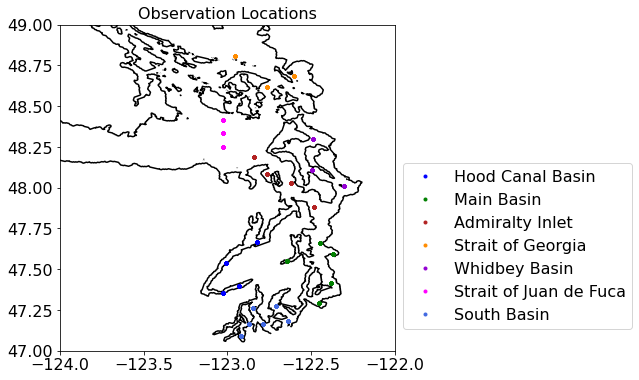

In [13]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
for ind, iregion in enumerate(data_CTD.Basin.unique()):
    ax.plot(datreg_CTD[iregion]['Lon'], datreg_CTD[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

# Absolute Salinity (g/kg)

### Table containing evaluation statistics for relevant subsets

In [14]:
# Setting Variable for Temperature. 
obsvar='SA'
modvar='mod_vosaline'
regions=data_CTD.Basin.unique()

In [15]:
statsDict_CTSA={year:dict()}
statsDict_CTSA[year]['SA']=OrderedDict()
for isub in statsubs_CTD:
    print(isub)
    statsDict_CTSA[year]['SA'][isub]=dict()
    var=statsDict_CTSA[year]['SA'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]],
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_CTSA[year]['SA'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, DJF
z < 15 m, MAM
z < 15 m, JJA
z < 15 m, SON
Hood Canal Basin
Main Basin
Admiralty Inlet
Strait of Georgia
Whidbey Basin
Strait of Juan de Fuca
South Basin


### Model vs Observed comparisons by depth and region

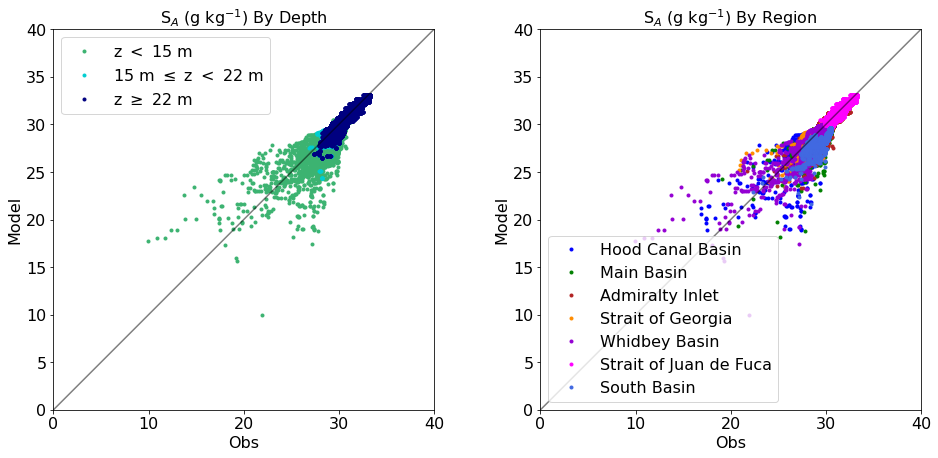

In [16]:
lims=(0,40)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_CTD,obsvar,modvar,lims)
ax[0].set_title('S$_A$ (g kg$^{-1}$) By Depth')

ps,l=ket.byRegion(ax[1],data_CTD,datreg_CTD,obsvar,modvar,lims)
ax[1].set_title('S$_A$ (g kg$^{-1}$) By Region');

### A closer look at Salinity in South Basin

### 2D Histogram of model vs observed

Text(0.5, 1.0, 'S$_A$ (g kg$^{-1}$)')

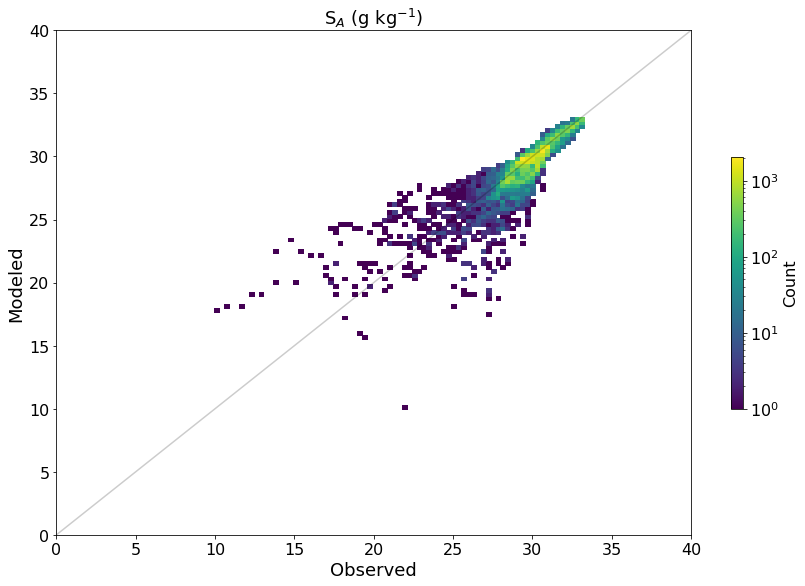

In [17]:
fig, ax = plt.subplots(1,1,figsize= (12,8))
ps = ket.hist2d(ax,fig,data_CTD,obsvar,modvar,lims,fontsize=18)
ax.set_title('S$_A$ (g kg$^{-1}$)',fontsize=18)

### 2d histograms of individual regions

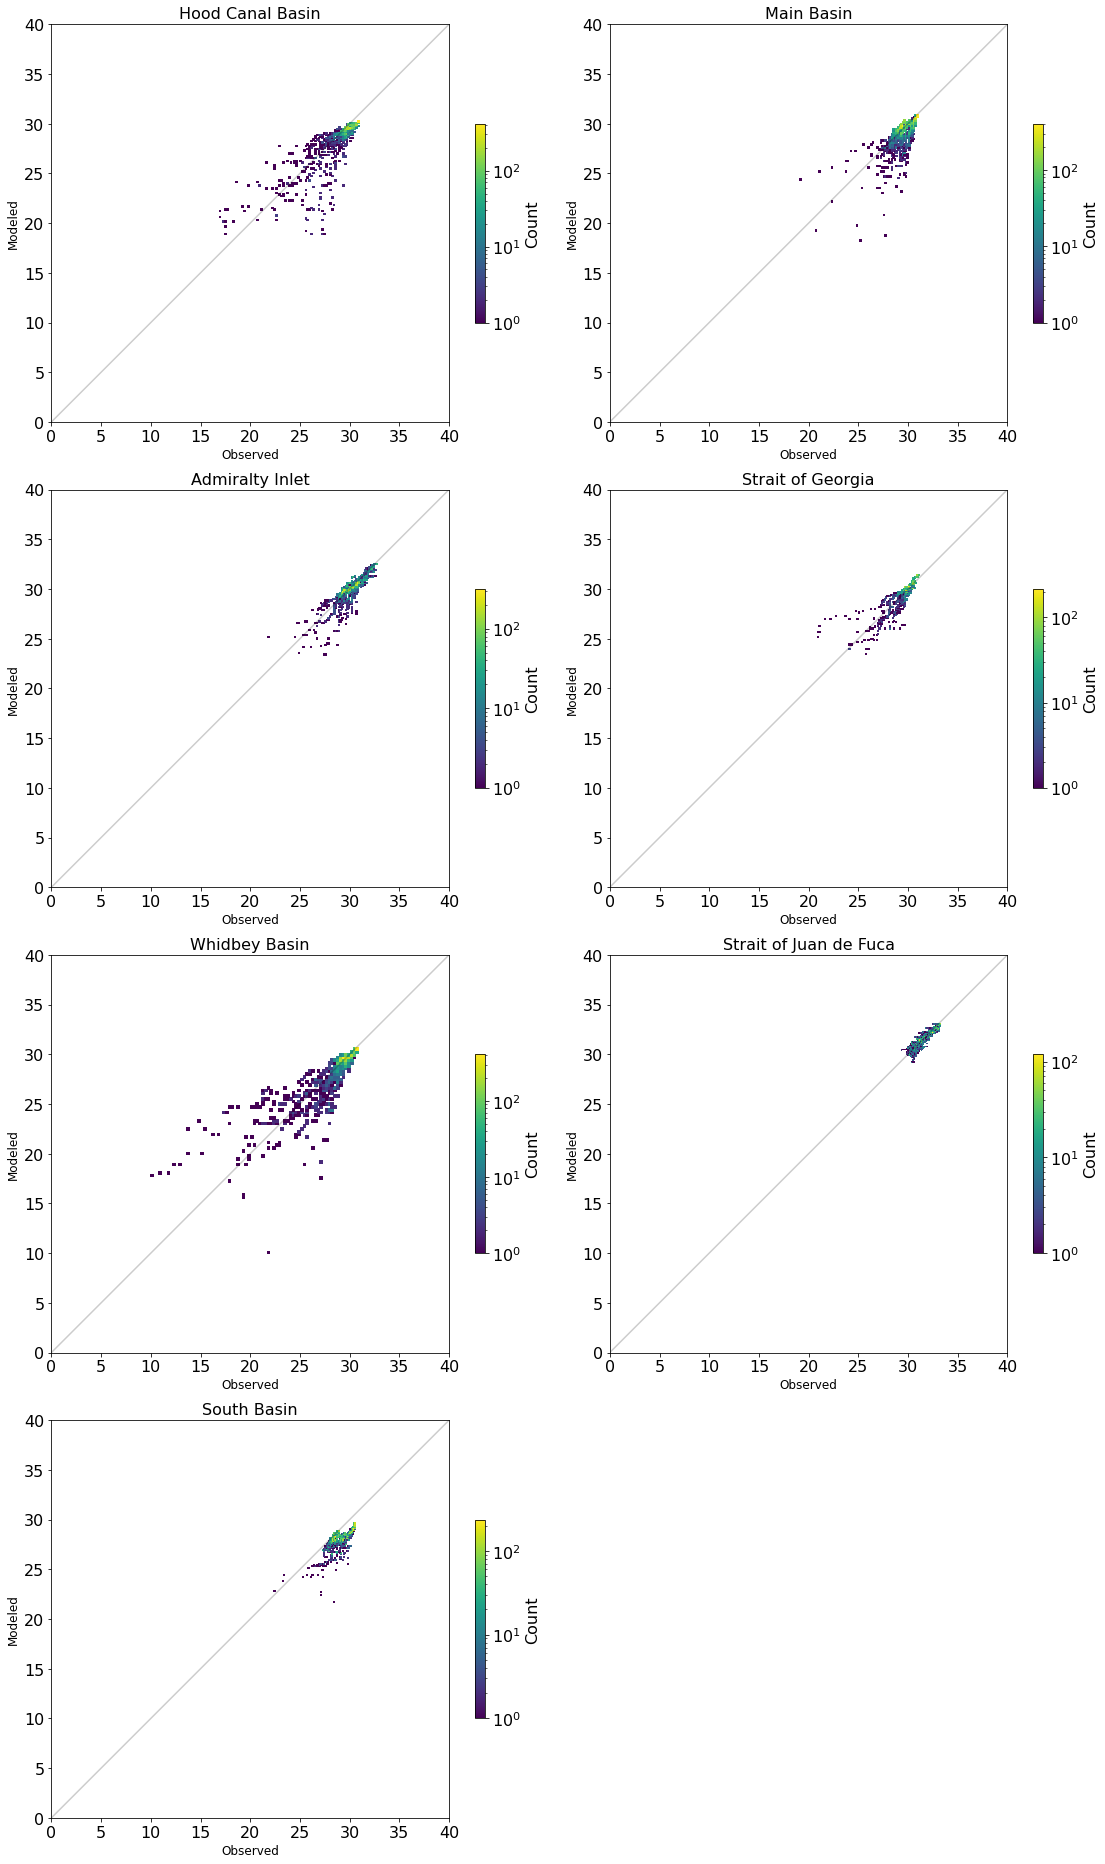

In [18]:
ax=ket.byRegion_hist2d(datreg_CTD,regions,obsvar,modvar,lims)

### Model vs observed comparisons for multiple seasons

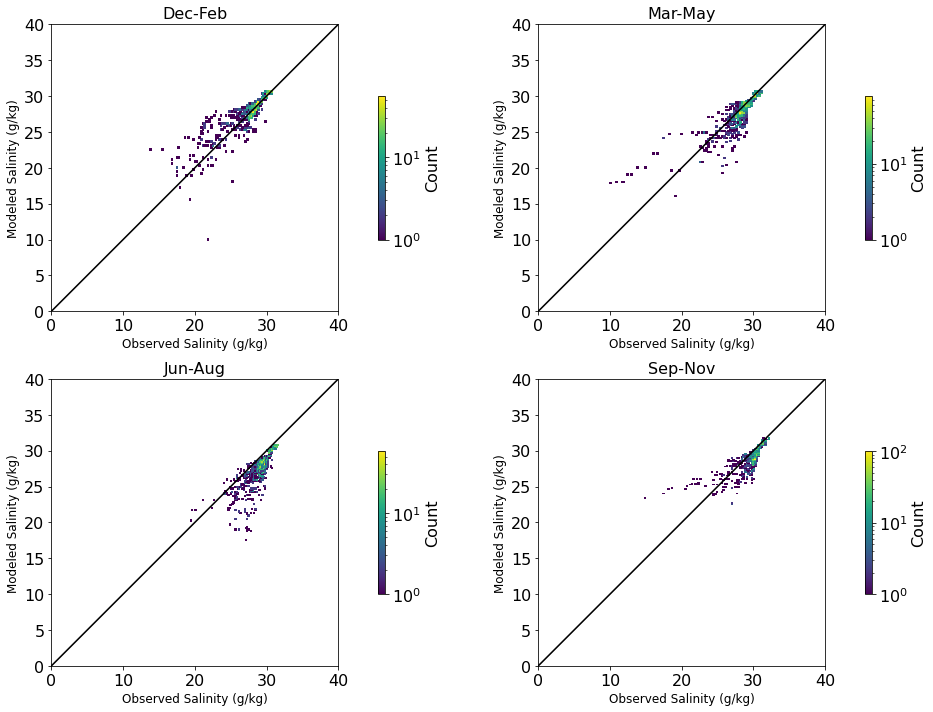

In [19]:
seasons=[DJF_CTD,MAM_CTD,JJA_CTD,SON_CTD]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(2,2,figsize = (18,10))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims,season_titles)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled Salinity (g/kg)')
        ax[i][j].set_xlabel('Observed Salinity (g/kg)')   

# Conservative Temperature

In [20]:
#Setting variables for temperature.
obsvar='CT'
modvar='mod_votemper'

### Table containing evaluation statistics for relevant subsets

In [21]:
statsDict_CTSA[year]['CT']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_CTSA[year]['CT'][isub]=dict()
    var=statsDict_CTSA[year]['CT'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]],
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_CTSA[year]['CT'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Model vs Observed comparisons by depth and region

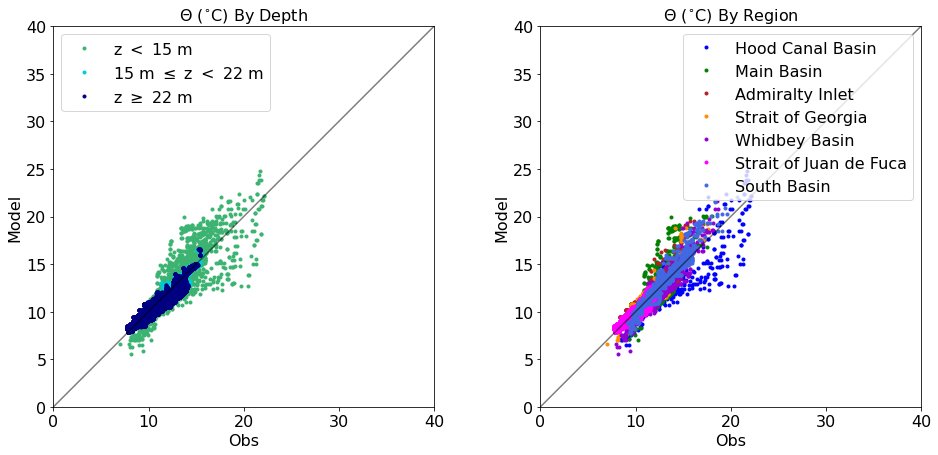

In [22]:
lims=(0,40)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_CTD,obsvar,modvar,lims)
ax[0].set_title('$\Theta$ ($^{\circ}$C) By Depth')

ps,l=ket.byRegion(ax[1],data_CTD,datreg_CTD,obsvar,modvar,lims)
ax[1].set_title('$\Theta$ ($^{\circ}$C) By Region');

### 2D Histogram of model vs observed

Text(0.5, 1.0, '$\\Theta$ ($^{\\circ}$C)')

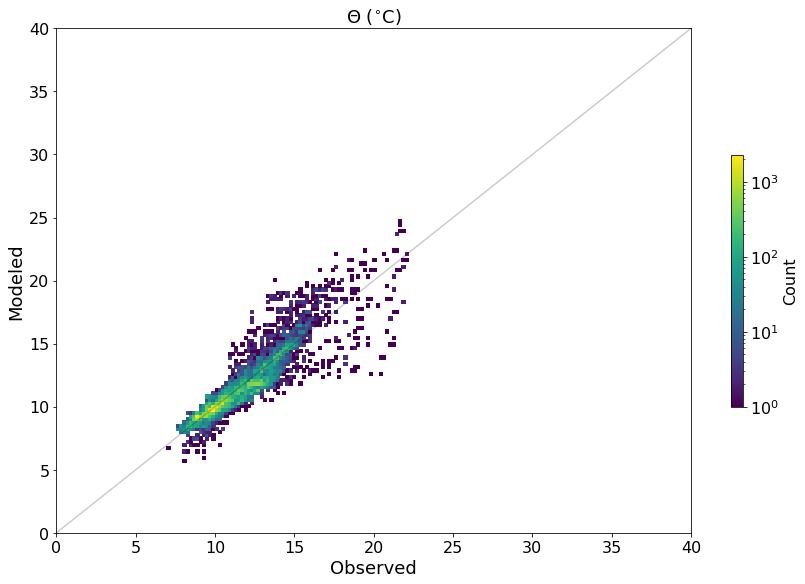

In [23]:
fig, ax = plt.subplots(1,1,figsize= (12,8))
ps = ket.hist2d(ax,fig,data_CTD,obsvar,modvar,lims,fontsize=18)
ax.set_title('$\Theta$ ($^{\circ}$C)',fontsize=18)

### 2d histograms of individual regions

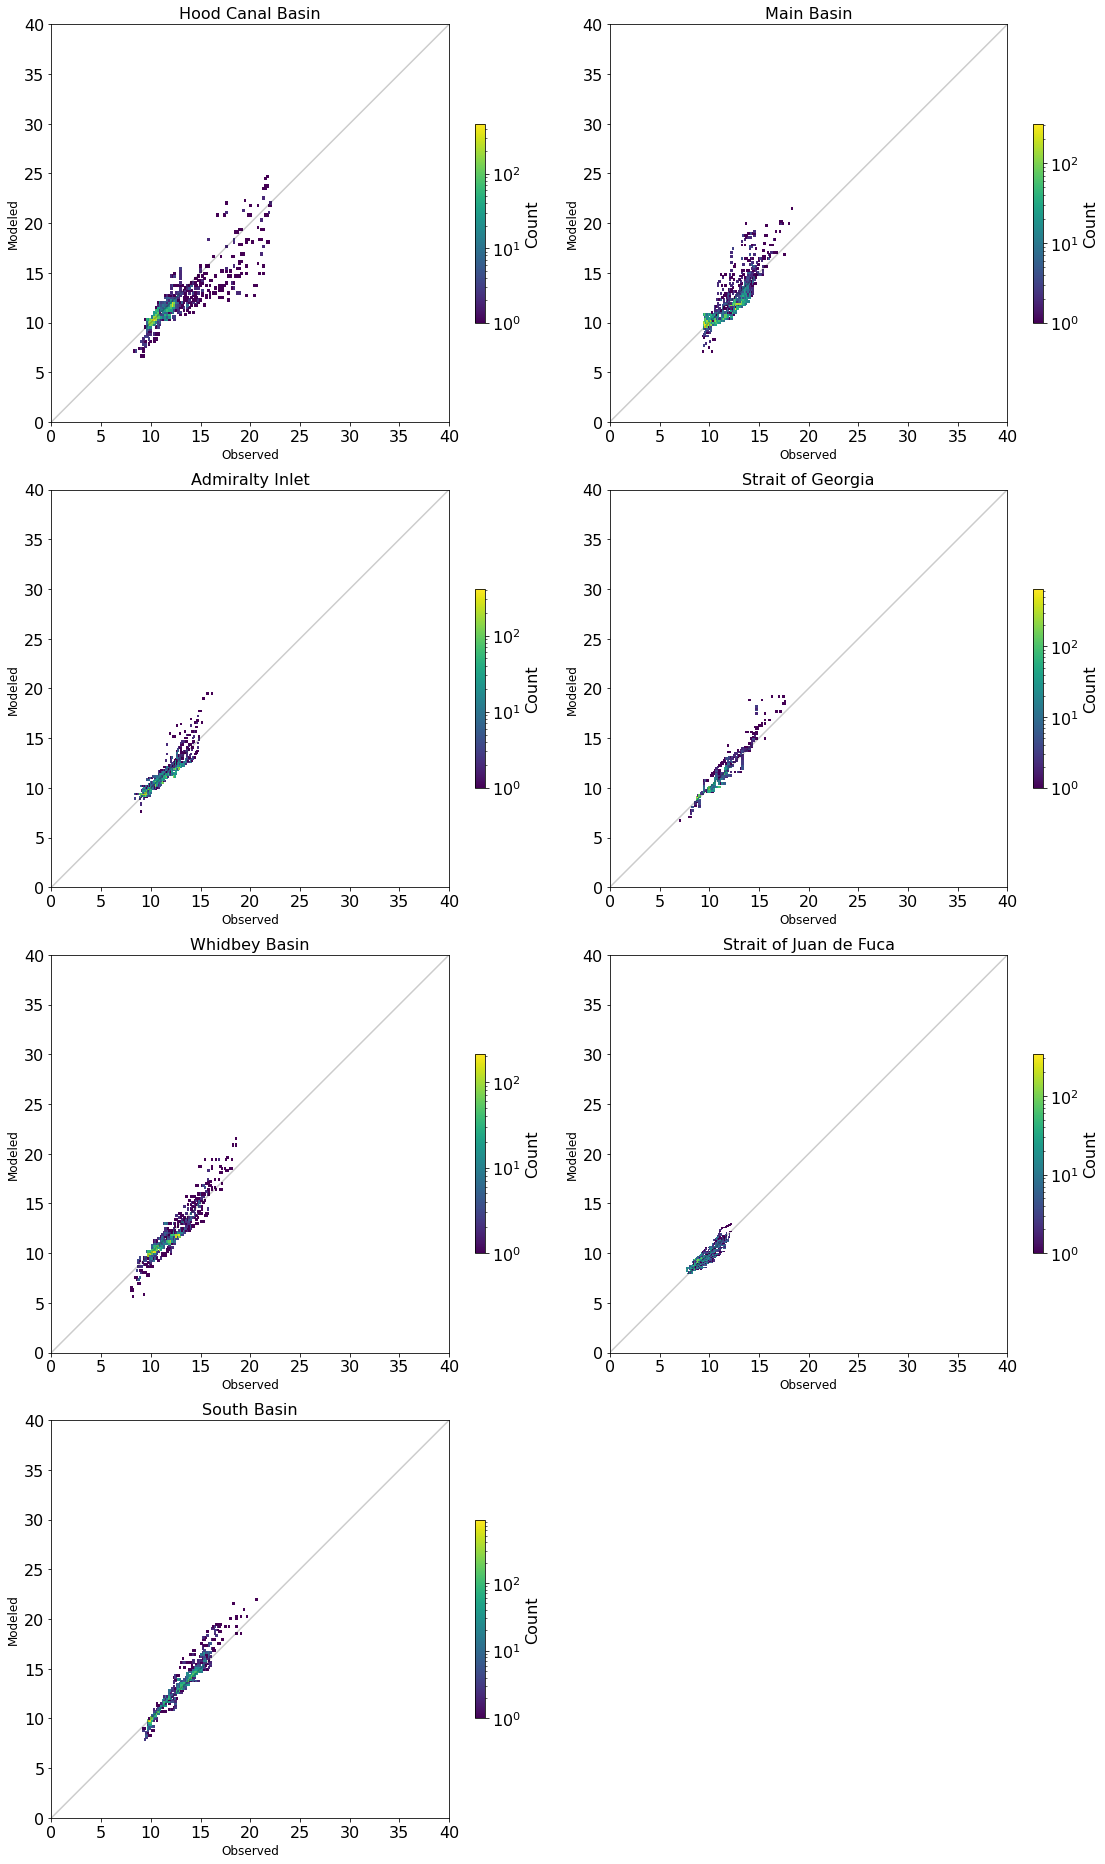

In [24]:
ax=ket.byRegion_hist2d(datreg_CTD,regions,obsvar,modvar,lims)

### Model vs observed comparisons for multiple seasons

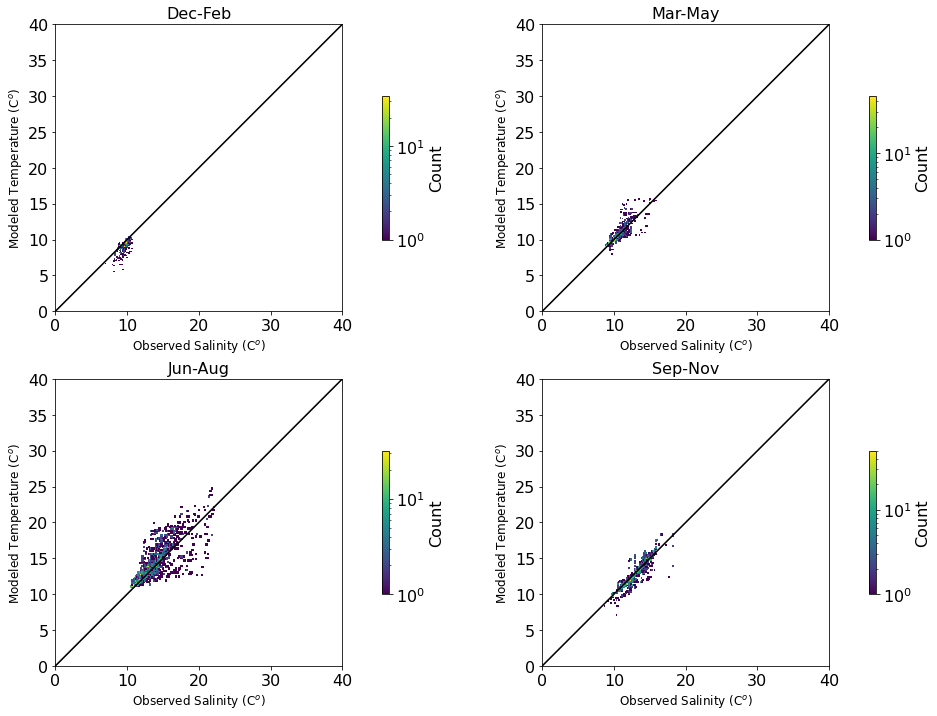

In [25]:
seasons=[DJF_CTD,MAM_CTD,JJA_CTD,SON_CTD]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(2,2,figsize = (18,10))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims,season_titles)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled Temperature (C$^o$)')
        ax[i][j].set_xlabel('Observed Salinity (C$^o$)')   

### Temperature-Salinity by Region

In [26]:
def tsplot(ax,svar,tvar):
    limsS=(0,36)
    limsT=(5,20)
    ss,tt=np.meshgrid(np.linspace(limsS[0],limsS[1],20),np.linspace(limsT[0],limsT[1],20))
    rho=gsw.rho(ss,tt,np.zeros(np.shape(ss)))
    r=ax.contour(ss,tt,rho,colors='k')
    ps=list()
    for ind, iregion in enumerate(data_CTD.Basin.unique()):
        p=ax.plot(datreg_CTD[iregion][svar], datreg_CTD[iregion][tvar],'.',
                color = colors[ind], label=iregion)
        ps.append(p[0])
    l=ax.legend(handles=ps,bbox_to_anchor=(1.01,1))
    ax.set_ylim(limsT)
    ax.set_xlim(limsS)
    ax.set_ylabel('$\Theta$ ($^{\circ}$C)')
    ax.set_xlabel('S$_A$ (g kg$^{-1}$)')
    ax.set_aspect((limsS[1]-limsS[0])/(limsT[1]-limsT[0]))
    return

Text(0.5, 1.0, 'Modelled')

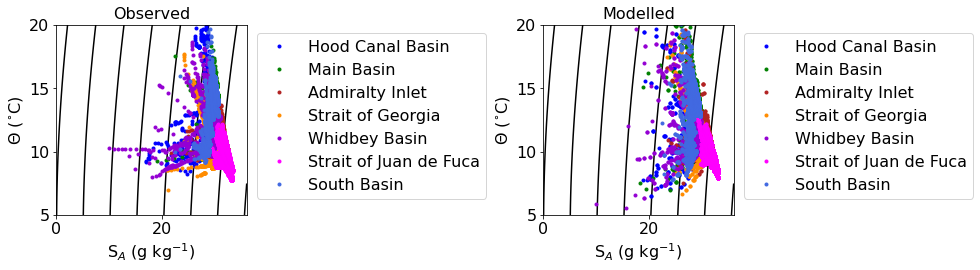

In [27]:
fig,ax=plt.subplots(1,2,figsize=(16,3.5))
tsplot(ax[0],'SA','CT')
ax[0].set_title('Observed')
tsplot(ax[1],'mod_vosaline','mod_votemper')
ax[1].set_title('Modelled')

### Summary table of temperature and salinity evaluation statistics

In [28]:
tbl,tdf=et.displayStats(statsDict_CTSA[year],level='Variable',suborder=list(statsubs_CTD.keys()))
tbl

# Observed Chlorophyll vs Model Phytoplankton

In [29]:
#Setting variables for Chlorophyll.
obsvar='Chl'
modvar='mod_diatoms'

## Model Diatoms vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets

In [30]:
statsDict_Chl={year:dict()}
statsDict_Chl[year]['Diatoms']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_Chl[year]['Diatoms'][isub]=dict()
    var=statsDict_Chl[year]['Diatoms'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Diatoms'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

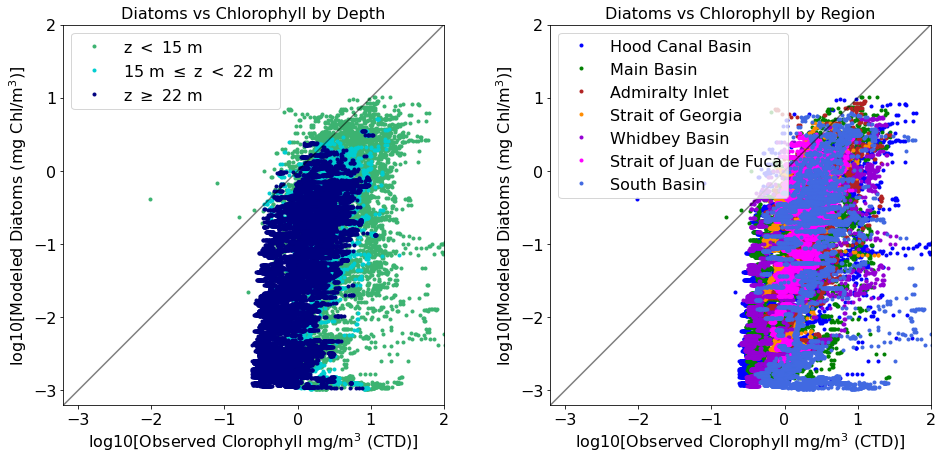

In [31]:
obsvar='log_Chl'
modvar='log_mod_diatoms'

lims=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_CTD,obsvar,modvar,lims)
ax[0].set_title('Diatoms vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Modeled Diatoms (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')   

ps,l=ket.byRegion(ax[1],data_CTD,datreg_CTD,obsvar,modvar,lims)
ax[1].set_title('Diatoms vs Chlorophyll by Region');
ax[1].set_ylabel('log10[Modeled Diatoms (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]') 

### 2D Histogram of model diatoms vs observed cholophyll

Text(0.5, 28.0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

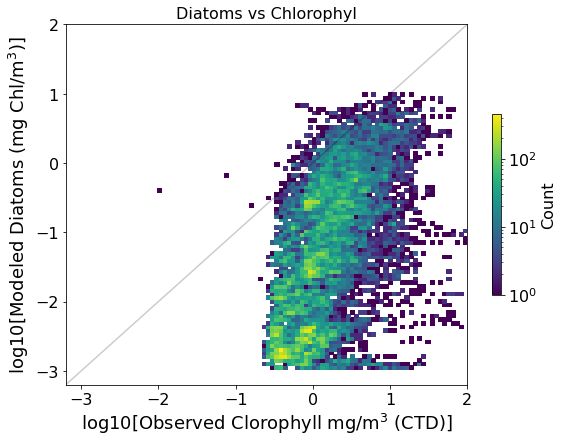

In [32]:
fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = ket.hist2d(ax,fig,data_CTD,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_title('Diatoms vs Chlorophyl')
ax.set_ylabel('log10[Modeled Diatoms (mg Chl/m$^3$)]')
ax.set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')  

### 2d histograms of individual regions

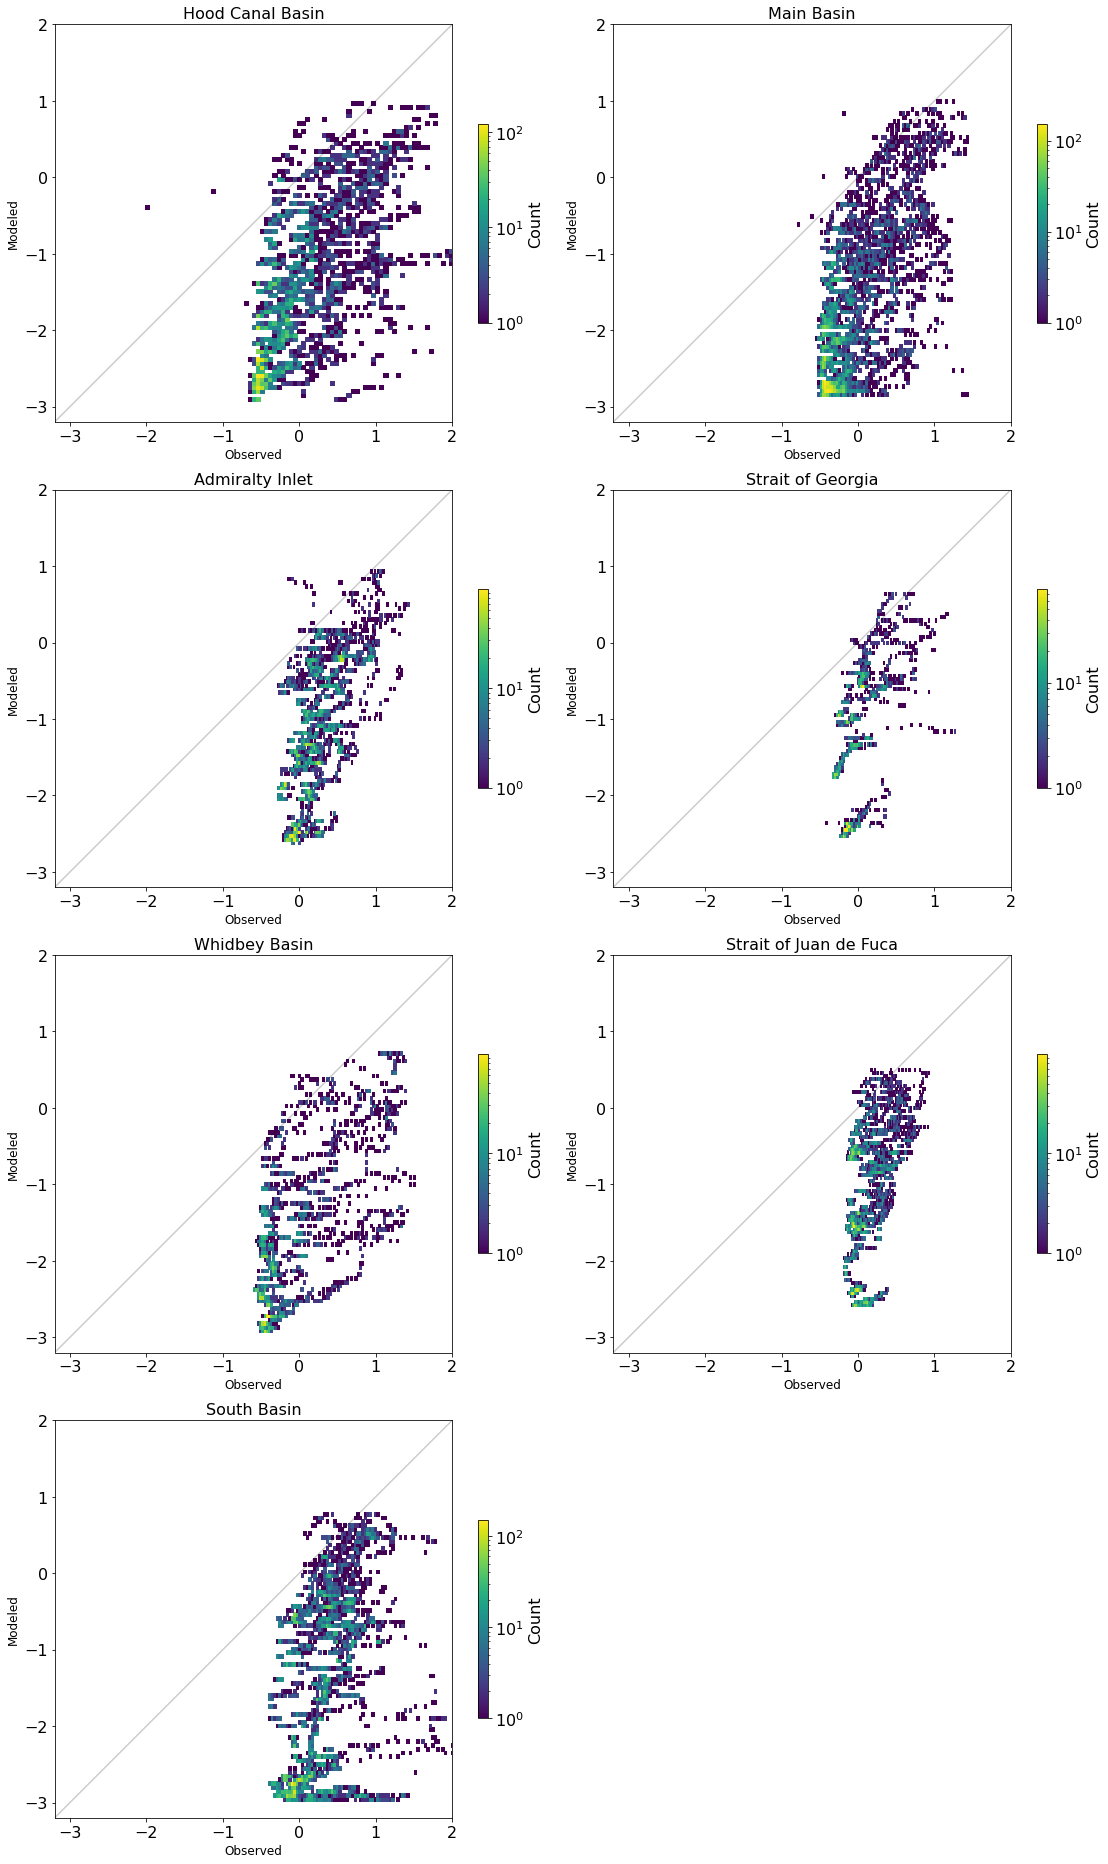

In [33]:
ax=ket.byRegion_hist2d(datreg_CTD,regions,obsvar,modvar,lims)

### Model vs observed comparisons for multiple seasons

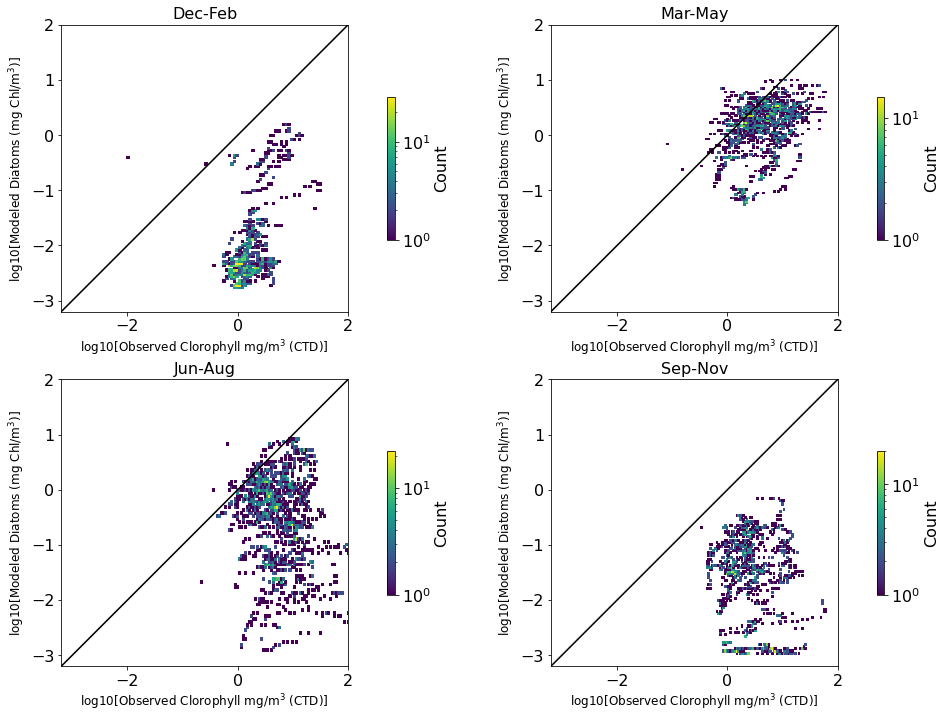

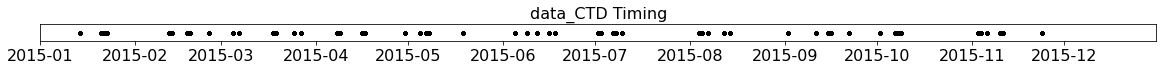

In [34]:
seasons=[DJF_CTD,MAM_CTD,JJA_CTD,SON_CTD]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(2,2,figsize = (18,10))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims,season_titles)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('log10[Modeled Diatoms (mg Chl/m$^3$)]')
        ax[i][j].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')   
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

## Model Ciliates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [35]:
obsvar='Chl'
modvar='mod_ciliates'

statsDict_Chl[year]['Ciliates']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_Chl[year]['Ciliates'][isub]=dict()
    var=statsDict_Chl[year]['Ciliates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Ciliates'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

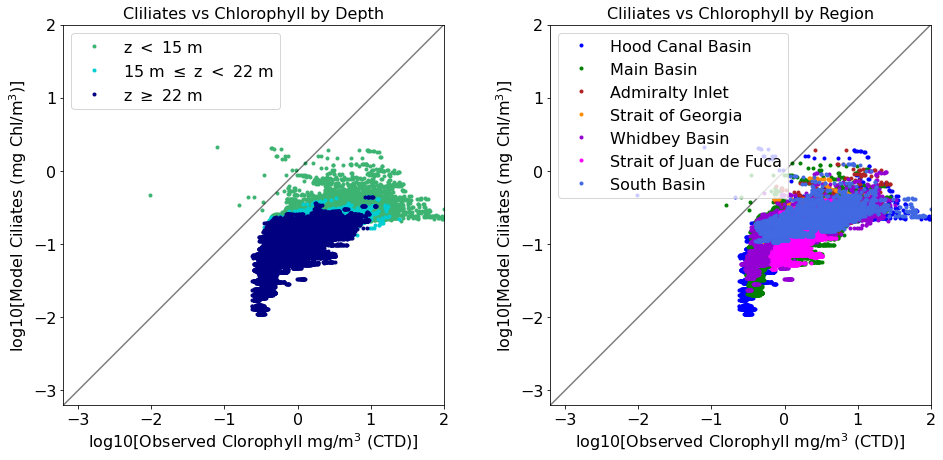

In [36]:
obsvar='log_Chl'
modvar='log_mod_ciliates'

lims=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_CTD,obsvar,modvar,lims)
ax[0].set_title('Cliliates vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')  

ps,l=ket.byRegion(ax[1],data_CTD,datreg_CTD,obsvar,modvar,lims)
ax[1].set_title('Cliliates vs Chlorophyll by Region')
ax[1].set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]') 

### 2D Histogram of model ciliates vs observed chlorophyll

Text(0.5, 28.0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

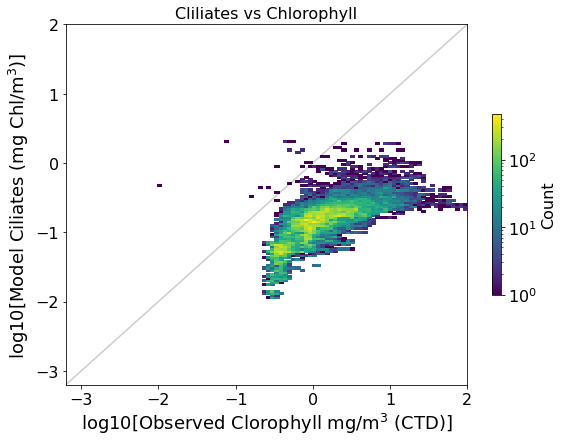

In [37]:
fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = ket.hist2d(ax,fig,data_CTD,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_title('Cliliates vs Chlorophyll')
ax.set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax.set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')

### 2D Histograms of individual regions

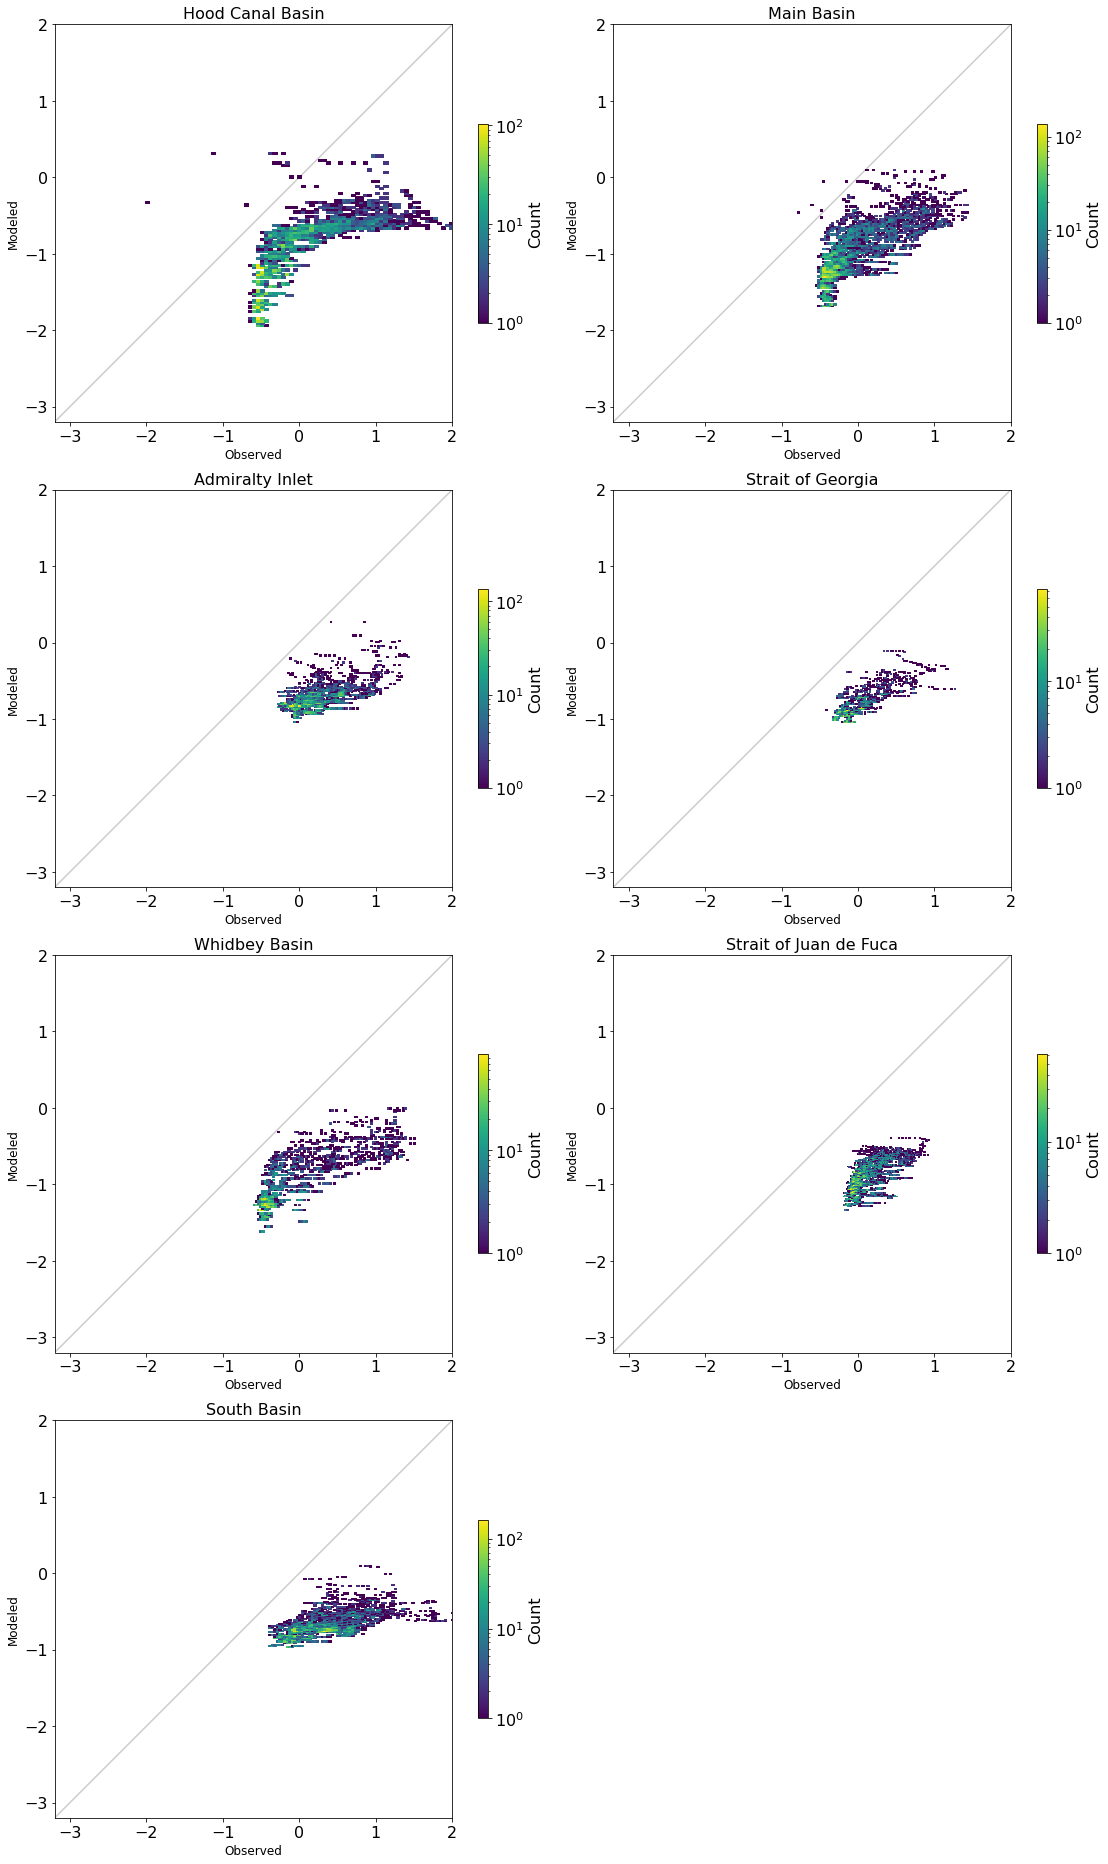

In [38]:
ax=ket.byRegion_hist2d(datreg_CTD,regions,obsvar,modvar,lims)

## Model Ciliates vs observed Chlorophyll comparisons for multiple seasons

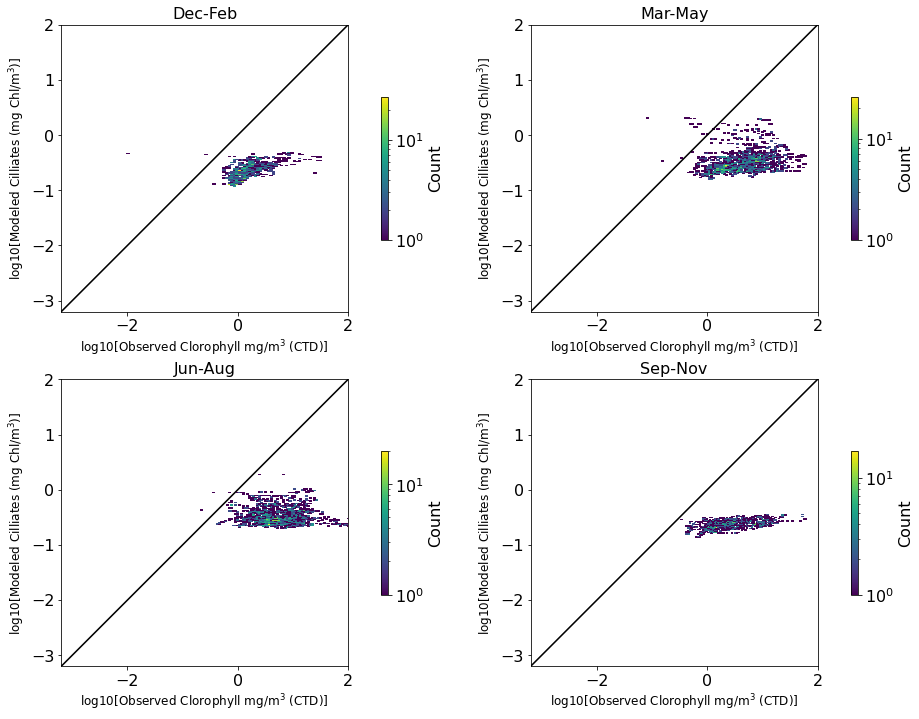

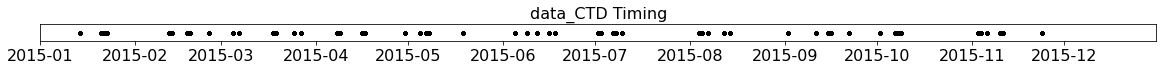

In [39]:
seasons=[DJF_CTD,MAM_CTD,JJA_CTD,SON_CTD]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(2,2,figsize = (16,10))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims,season_titles)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('log10[Modeled Cilliates (mg Chl/m$^3$)]')
        ax[i][j].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')  
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

## Model Flagellates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [40]:
obsvar='Chl'
modvar='mod_flagellates'

statsDict_Chl[year]['Flagellates']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_Chl[year]['Flagellates'][isub]=dict()
    var=statsDict_Chl[year]['Flagellates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Flagellates'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

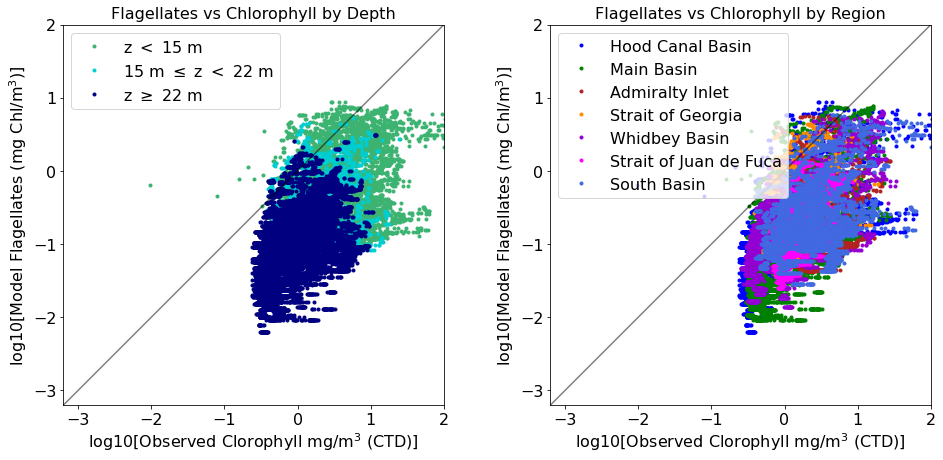

In [41]:
obsvar='log_Chl'
modvar='log_mod_flagellates'

lims=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_CTD,obsvar,modvar,lims)
ax[0].set_title('Flagellates vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')  

ps,l=ket.byRegion(ax[1],data_CTD,datreg_CTD,obsvar,modvar,lims)
ax[1].set_title('Flagellates vs Chlorophyll by Region')
ax[1].set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]') 

### 2D Histogram of model flagellates vs observed Chlorophyll

Text(0.5, 28.0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

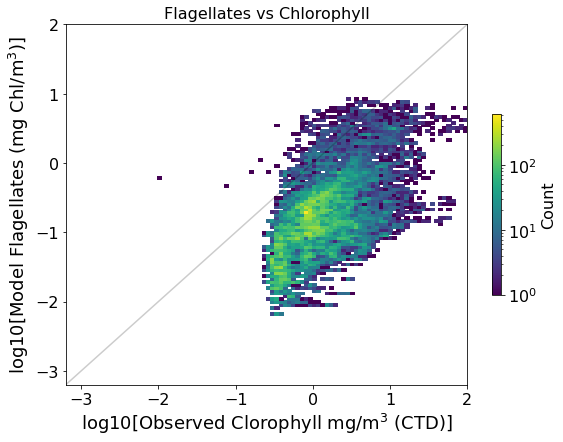

In [42]:
fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = ket.hist2d(ax,fig,data_CTD,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_title('Flagellates vs Chlorophyll')
ax.set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
ax.set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]') 

### 2D Histograms of individual regions

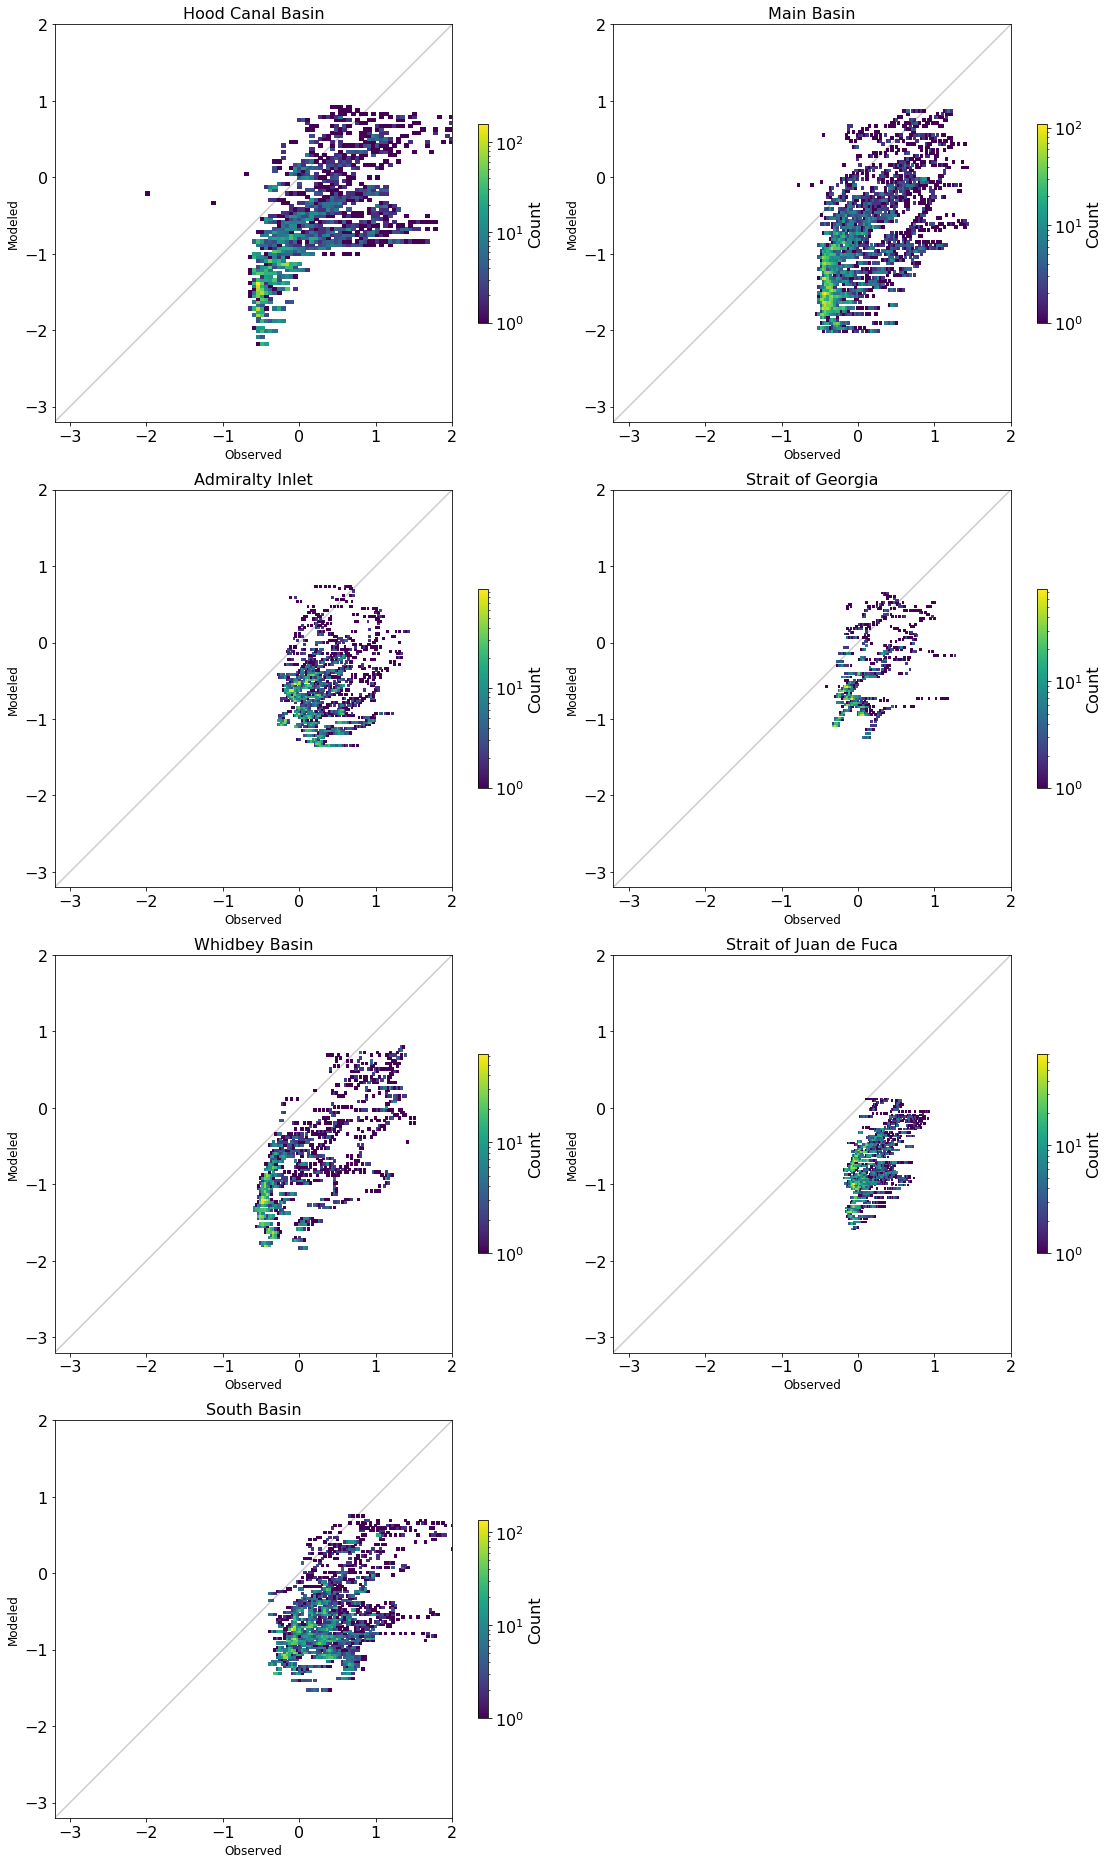

In [43]:
ax=ket.byRegion_hist2d(datreg_CTD,regions,obsvar,modvar,lims)

### Model flagellates vs observed Chlorophyll comparisons for multiple seasons

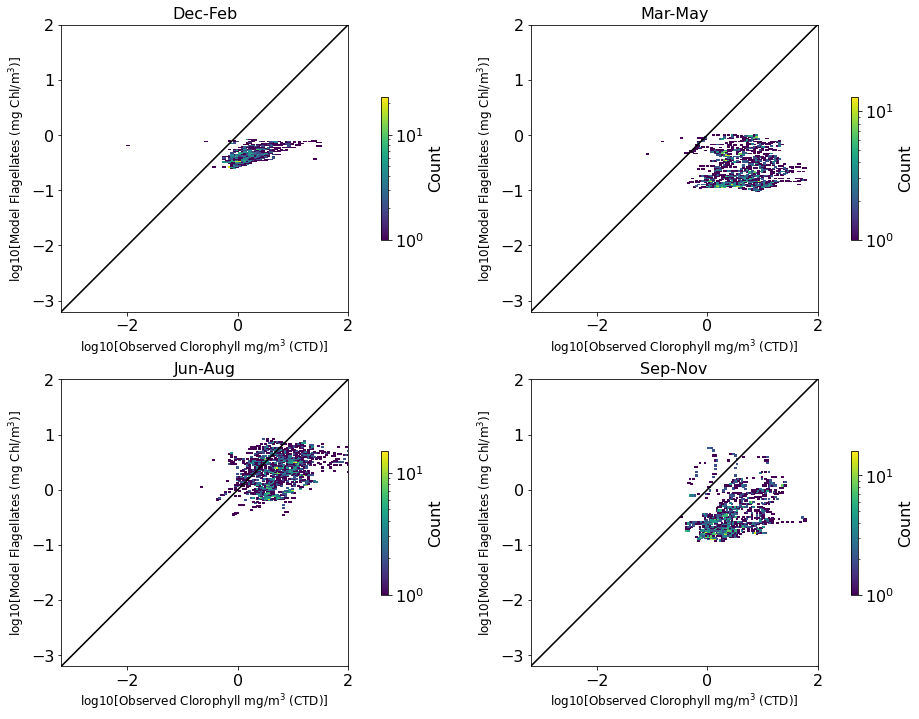

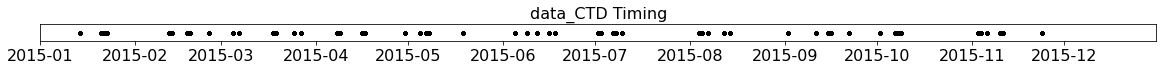

In [44]:
seasons=[DJF_CTD,MAM_CTD,JJA_CTD,SON_CTD]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(2,2,figsize = (16,10))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims,season_titles)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
        ax[i][j].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

## All Model Phytoplankton vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [45]:
obsvar='Chl'
modvar='mod_Chl'

statsDict_Chl[year]['All']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_Chl[year]['All'][isub]=dict()
    var=statsDict_Chl[year]['All'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['All'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

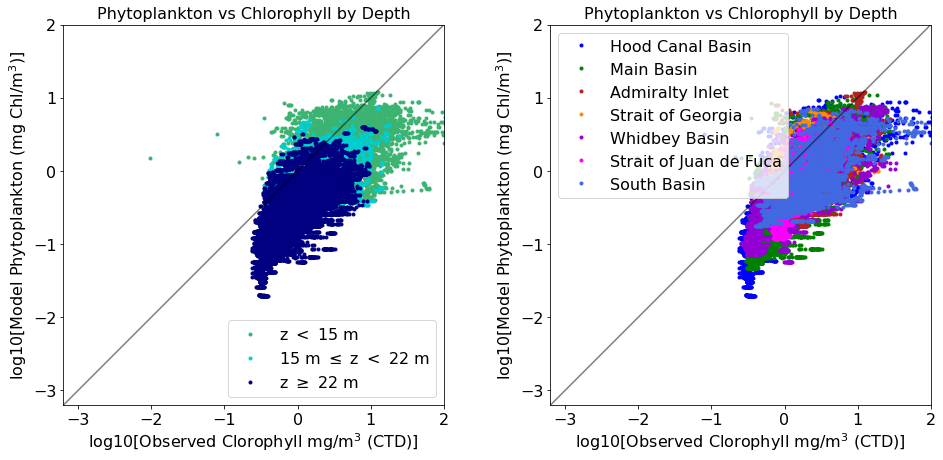

In [46]:
obsvar='log_Chl'
modvar='log_mod_Chl'

lims=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_CTD,obsvar,modvar,lims)
ax[0].set_title('Phytoplankton vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Phytoplankton (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]') 

ps,l=ket.byRegion(ax[1],data_CTD,datreg_CTD,obsvar,modvar,lims)
ax[1].set_title('Phytoplankton vs Chlorophyll by Depth')
ax[1].set_ylabel('log10[Model Phytoplankton (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]') 

### 2D Histogram of all model phytoplankton vs observed Chlorophyll

Text(0.5, 28.0, 'log10[Observed Chlorophyll mg/m$^3$ (CTD)]')

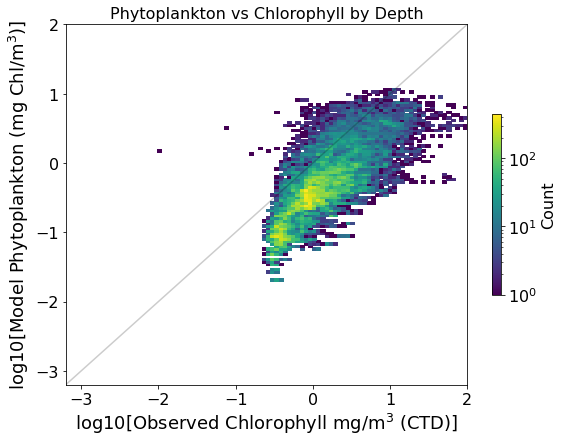

In [47]:
obsvar='log_Chl'
modvar='log_mod_Chl'

fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = ket.hist2d(ax,fig,data_CTD,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_title('Phytoplankton vs Chlorophyll by Depth')
ax.set_ylabel('log10[Model Phytoplankton (mg Chl/m$^3$)]')
ax.set_xlabel('log10[Observed Chlorophyll mg/m$^3$ (CTD)]') 

### 2D Histograms of individual regions

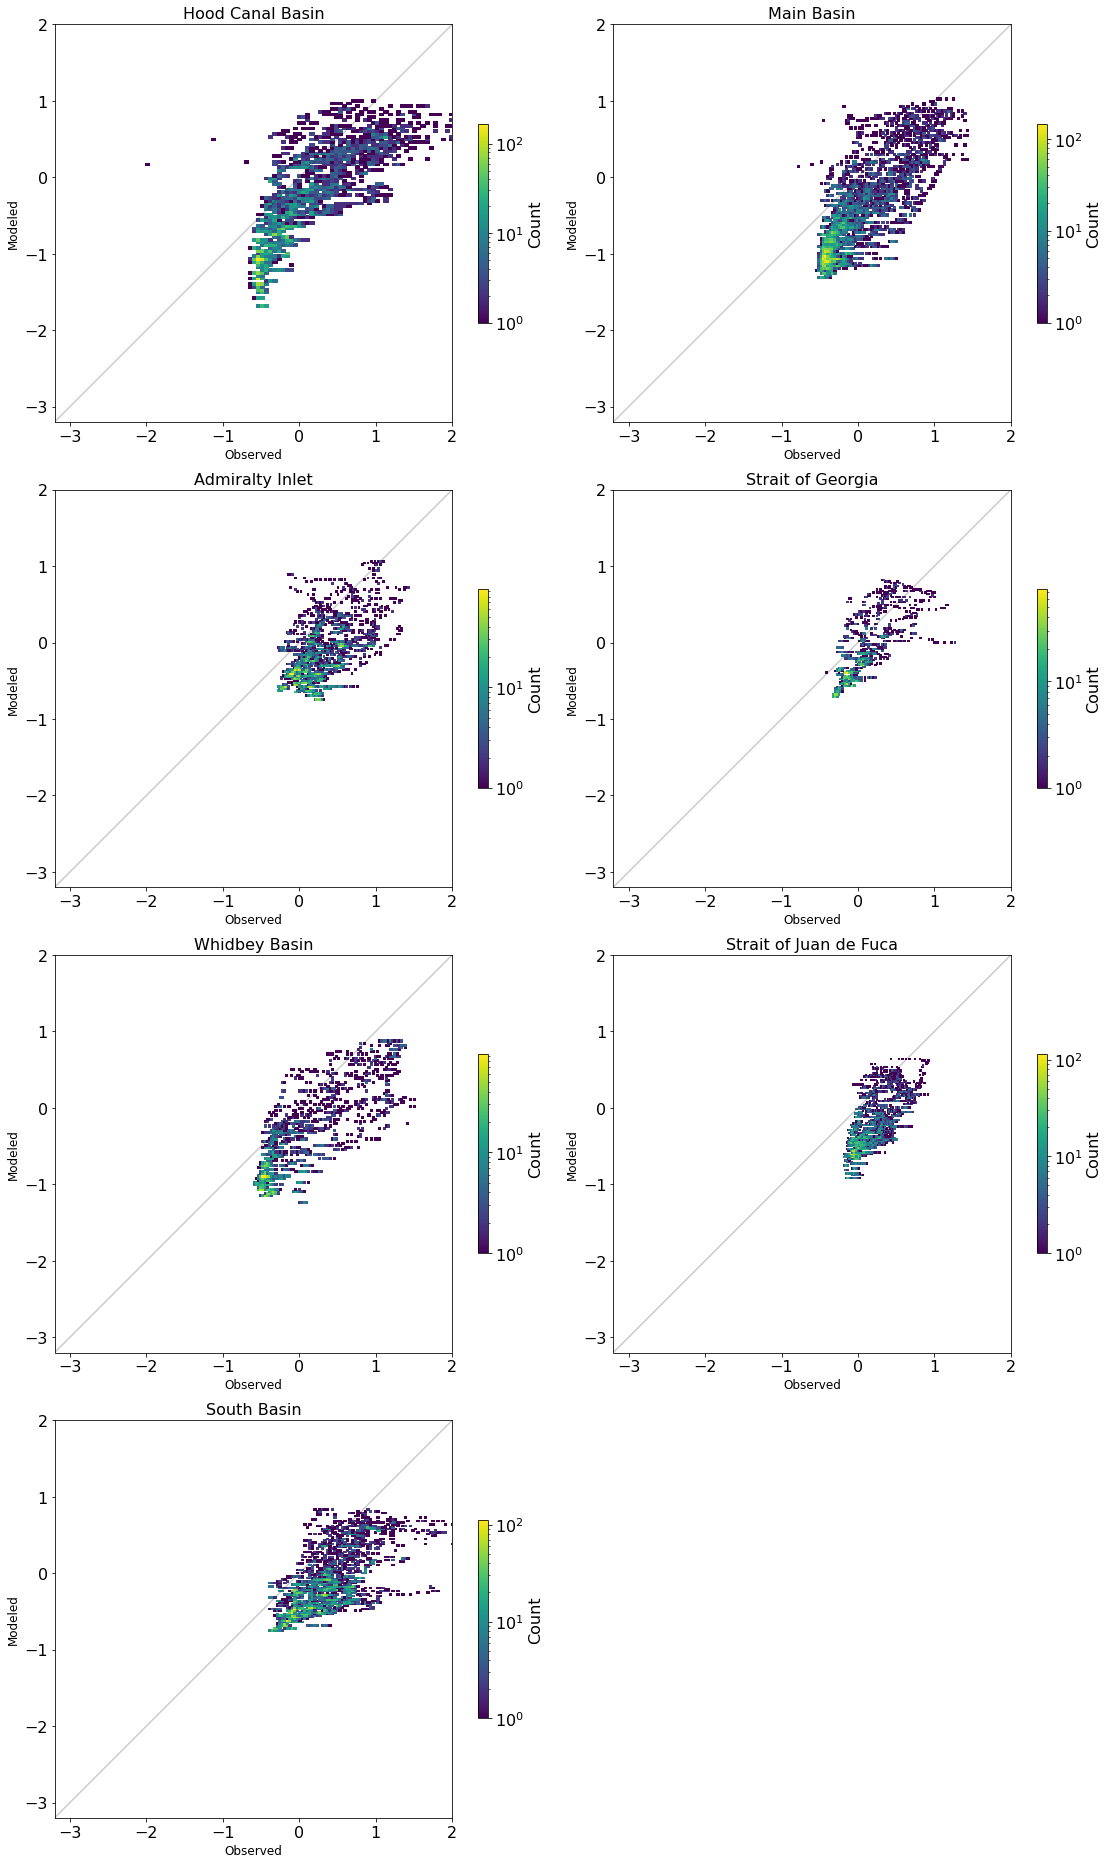

In [48]:
ax=ket.byRegion_hist2d(datreg_CTD,regions,obsvar,modvar,lims)

## Model Phytoplankton vs observed Chlorophyll comparisons for multiple seasons

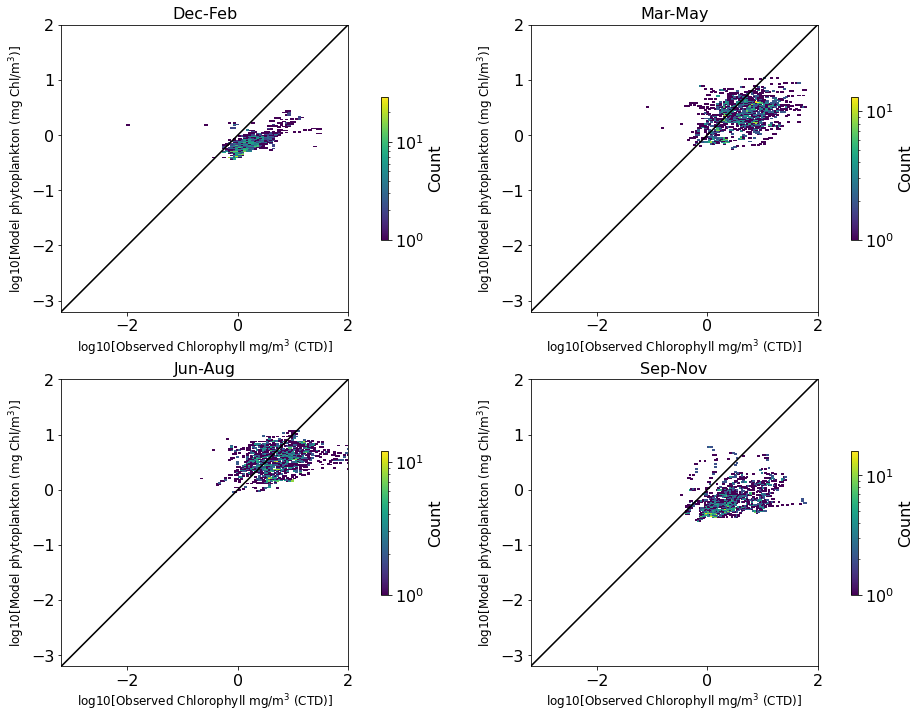

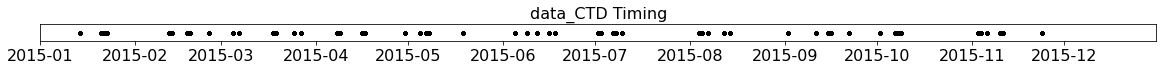

In [49]:
seasons=[DJF_CTD,MAM_CTD,JJA_CTD,SON_CTD]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(2,2,figsize = (16,10))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,(-3.2,2),season_titles)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('log10[Model phytoplankton (mg Chl/m$^3$)]')
        ax[i][j].set_xlabel('log10[Observed Chlorophyll mg/m$^3$ (CTD)]')
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

### Summary table of evaluation statistics for Observed Chlorophyll Model Phytoplankton comparisons.

In [50]:
tbl,tdf=et.displayStats(statsDict_Chl[year],level='Variable',suborder=list(statsubs_CTD.keys()))
tbl